# Intelligent Loan Approval Prediction System ML Models
The system is designed to predict the likelihood of loan approval by analyzing historical data containing applicants’ financial and personal attributes. By employing advanced ML algorithms, the model can capture complex patterns and relationships between features, enabling more informed and objective predictions.

In this project, multiple machine learning models are explored and compared to identify the most effective approach for predicting loan approvals. The selected models include:

- Logistic Regression
- Random Forest
- XGBoost
- LightGBM
- Support Vector Machine (SVM)
- Neural Network

By training and evaluating these models on historical loan datasets, the system aims to provide a reliable, data-driven mechanism for loan approval prediction. This approach not only helps financial institutions minimize default risk but also ensures a fair and consistent evaluation process for applicants.

# Import Libraries

In [1]:
# records and calculations
import pandas as pd
import numpy as np

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# core ML
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, confusion_matrix
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import calibration_curve

# gradient boosting model
import lightgbm as lgb
import xgboost as xgb

# neural network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier

# optimization
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)        # reduce Optuna's logging output to only warnings and errors (hides trial info logs)

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# Interpretability
import shap

# Fairness
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference

# Persistence
import joblib
import pickle

#  Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# avoid minor warnings
import warnings
warnings.filterwarnings('ignore')

# read file path
from pathlib import Path

c:\Users\Tshihab07\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load and Prepare Dataset for Modeling 

## Load Dataset

In [2]:
# reading file path
file = Path(r"../data/CleanedLoanData.csv")

# reading csv file
df = pd.read_csv(file)

In [3]:
df.head()

,Dependents,LoanAmount,CreditHistory,LoanStatus,TotalIncome,IncomeLoanRatio,LoanTermYears,Has_CoApplicantIncome,Gender_Male,Married_Yes,Education_NotGraduate,PropertyArea_Semiurban,PropertyArea_Urban,SelfEmployed_Yes
0,0,146.369492,1,1,5849.0,25.024704,30.0,0,True,False,False,False,True,False
1,1,128.000000,1,0,6091.0,21.014612,30.0,1,True,True,False,False,False,False
2,0,66.000000,1,1,3000.0,22.000000,30.0,0,True,True,False,False,True,True
3,0,120.000000,1,1,4941.0,24.286582,30.0,1,True,True,True,False,True,False
4,0,141.000000,1,1,6000.0,23.500000,30.0,0,True,False,False,False,True,False


## Feature-Target Separation

In [4]:
# input features
x = df.drop(columns=['LoanStatus'],  axis=1)

# target variable
y = df['LoanStatus']

## Train-Test Split and Cross-Validation Setup

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring_metric = 'roc_auc'

In [6]:
# Initialize storages
all_results = {}
models = {}
probability = {}
predictions = {}
performance = []

# Model Development

## Logistic Regression

### Model Training with Hyperparameter Optimization

In [7]:
# hyperparameter grid
lr_param_grid = {
    'C' : [0.1, 1, 10, 100],
    'penalty': ['l2', 'l1'],
    'solver': ['liblinear'],
    'class_weight': ['balanced']
}

In [8]:
# Initialize base model
lr = LogisticRegression(random_state=42, max_iter=1000)

# GridSearch Optimization
lr_grid = GridSearchCV(
    lr,
    lr_param_grid,
    cv=cv,
    scoring=scoring_metric,
    n_jobs=-1
)

In [9]:
# train model and identify best estimator
lr_grid.fit(x_train, y_train)

models['Logistic Regression'] = lr_grid.best_estimator_

### Apply Model to Make Prediction and Get Probabilities

In [10]:
# make prediction on training and test set
train_pred = models['Logistic Regression'].predict(x_train)
test_pred = models["Logistic Regression"].predict(x_test)

In [11]:
# get predicted probabilities
train_proba = models['Logistic Regression'].predict_proba(x_train)[:, 1]
test_proba = models['Logistic Regression'].predict_proba(x_test)[:, 1]

In [12]:
# store results
predictions["Logistic Regression"] = test_pred
probability["Logistic Regression"] = test_proba

### Evaluation of The Model Performance

In [13]:
# Training Metrics
train_auc_roc = roc_auc_score(y_train, train_proba)             # ROC-AUC score
train_auc_pr = average_precision_score(y_train, train_proba)    # average precision
train_acc = accuracy_score(y_train, train_pred)                 # accuracy score
train_precision = precision_score(y_train, train_pred)          # precision score
train_recall = recall_score(y_train, train_pred)                # recall score
train_f1 = f1_score(y_train, train_pred)                        # f1 score
train_accuracy = accuracy_score(y_train, train_pred)            # accuracy score

In [14]:
# Test Metrics
test_auc_roc = roc_auc_score(y_test, test_proba)             # ROC-AUC score
test_auc_pr = average_precision_score(y_test, test_proba)    # average precision
test_acc = accuracy_score(y_test, test_pred)                 # accuracy score
test_precision = precision_score(y_test, test_pred)          # precision score
test_recall = recall_score(y_test, test_pred)                # recall score
test_f1 = f1_score(y_test, test_pred)                        # f1 score
test_accuracy = accuracy_score(y_test, test_pred)            # accuracy score

In [15]:
# performance table
print("=== Optimized Logistic Regression Performance ===")

metrics = [
    ("AUC-ROC", train_auc_roc, test_auc_roc),
    ('AUC-PR', train_auc_pr, test_auc_pr),
    ("Precision", train_precision, test_precision),
    ("Recall", train_recall, test_recall),
    ("F1-Score", train_f1, test_f1),
    ("Accuracy", train_acc, test_acc),
]

# Print header
print(f"{'Metric':<15}{'Training':<12}{'Test':<12}")
print("-" * 39)

# Print each row using a loop
for name, train_val, test_val in metrics:
    print(f"{name:<15}{train_val:<12.4f}{test_val:<12.4f}")

=== Optimized Logistic Regression Performance ===
Metric         Training    Test        
---------------------------------------
AUC-ROC        0.7768      0.8785      
AUC-PR         0.8582      0.9230      
Precision      0.8102      0.8780      
Recall         0.8537      0.8571      
F1-Score       0.8314      0.8675      
Accuracy       0.7623      0.8211      


In [16]:
# store test set performance
performance.append({
        'Model': 'Logistic Regression',
        'AUC-ROC': test_auc_roc,
        'AUC-PR': test_auc_pr,
        'Precision': test_precision,
        'Recall': test_recall,
        'F1-Score': test_f1,
        'Accuracy': test_accuracy
    })

### ROC Curves

In [17]:
# roc curve for training and testing set
train_fpr, train_tpr, _ = roc_curve(y_train, train_proba)
test_fpr, test_tpr, _ = roc_curve(y_test, test_proba)

In [18]:
# calculate AUC for training and testing set
train_auc = auc(train_fpr, train_tpr)
test_auc = auc(test_fpr, test_tpr)

In [19]:
# figure size
plt.figure(figsize=(8, 4))

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

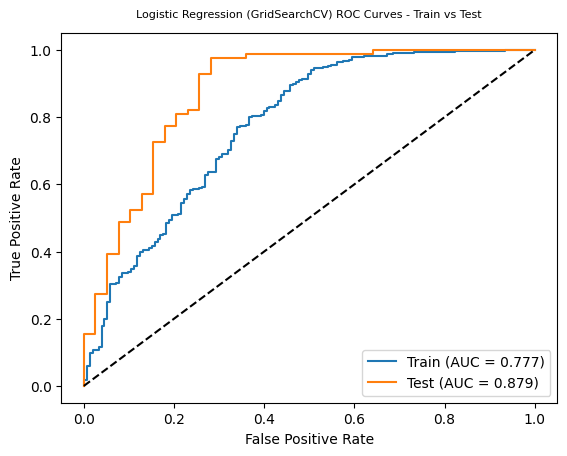

In [20]:
# ploting the curve
plt.plot(train_fpr, train_tpr, label=f'Train (AUC = {train_auc:.3f})')
plt.plot(test_fpr, test_tpr, label=f'Test (AUC = {test_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')

# set labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression (GridSearchCV) ROC Curves - Train vs Test',  y=1.02, fontsize=8)
plt.legend()
plt.show()

## Random Forest (GridSearchCV)

### Model Training with Hyperparameter Optimization

In [21]:
# hyperparameter grid
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced']
}

In [22]:
# Initialize base model
rf = RandomForestClassifier(random_state=42)

# GridSearch Optimization
rf_grid = GridSearchCV(
    rf,
    rf_param_grid,
    cv=cv,
    scoring=scoring_metric,
    n_jobs=-1
)

In [23]:
# train model and identify best estimator
rf_grid.fit(x_train, y_train)

models['Random Forest (GridSearchCV)'] = rf_grid.best_estimator_

### Apply Model to Make Prediction and Get Probabilities

In [24]:
# make prediction on training and test set
train_pred = models['Random Forest (GridSearchCV)'].predict(x_train)
test_pred = models["Random Forest (GridSearchCV)"].predict(x_test)

In [25]:
# get predicted probabilities
train_proba = models['Random Forest (GridSearchCV)'].predict_proba(x_train)[:, 1]
test_proba = models['Random Forest (GridSearchCV)'].predict_proba(x_test)[:, 1]

In [26]:
# store results
predictions["Random Forest (GridSearchCV)"] = test_pred
probability["Random Forest (GridSearchCV)"] = test_proba

### Evaluation of The Model Performance

In [27]:
# performance on training set
train_auc_roc = roc_auc_score(y_train, train_proba)             # ROC-AUC score
train_auc_pr = average_precision_score(y_train, train_proba)    # average precision
train_acc = accuracy_score(y_train, train_pred)                 # accuracy score
train_precision = precision_score(y_train, train_pred)          # precision score
train_recall = recall_score(y_train, train_pred)                # recall score
train_f1 = f1_score(y_train, train_pred)                        # f1 score
train_accuracy = accuracy_score(y_train, train_pred)            # accuracy score

In [28]:
# Test Metrics
test_auc_roc = roc_auc_score(y_test, test_proba)             # ROC-AUC score
test_auc_pr = average_precision_score(y_test, test_proba)    # average precision
test_acc = accuracy_score(y_test, test_pred)                 # accuracy score
test_precision = precision_score(y_test, test_pred)          # precision score
test_recall = recall_score(y_test, test_pred)                # recall score
test_f1 = f1_score(y_test, test_pred)                        # f1 score
test_accuracy = accuracy_score(y_test, test_pred)            # accuracy score

In [29]:
# performance table
print("=== Optimized Random Forest Performance ===")

metrics = [
    ("AUC-ROC", train_auc_roc, test_auc_roc),
    ('AUC-PR', train_auc_pr, test_auc_pr),
    ("Precision", train_precision, test_precision),
    ("Recall", train_recall, test_recall),
    ("F1-Score", train_f1, test_f1),
    ("Accuracy", train_acc, test_acc),
]

# Print header
print(f"{'Metric':<15}{'Training':<12}{'Test':<12}")
print("-" * 39)

# Print each row using a loop
for name, train_val, test_val in metrics:
    print(f"{name:<15}{train_val:<12.4f}{test_val:<12.4f}")

=== Optimized Random Forest Performance ===
Metric         Training    Test        
---------------------------------------
AUC-ROC        0.9105      0.8745      
AUC-PR         0.9542      0.9268      
Precision      0.8433      0.8571      
Recall         0.9642      0.9286      
F1-Score       0.8997      0.8914      
Accuracy       0.8525      0.8455      


In [30]:
performance.append({
    "Model": "Random Forest (GridSearchCV)",
    'AUC-ROC': test_auc_roc,
    'AUC-PR': test_auc_pr,
    'Precision': test_precision,
    'Recall': test_recall,
    'F1-Score': test_f1,
    'Accuracy': test_accuracy
})

### ROC Curve

In [31]:
# roc-curve for training and test set
train_fpr, train_tpr, _ = roc_curve(y_train, train_proba)
test_fpr, test_tpr, _ = roc_curve(y_test,  test_proba)

In [32]:
# calculate AUC for trainign and test set
train_auc = auc(train_fpr, train_tpr)
test_auc = auc(test_fpr, test_tpr)

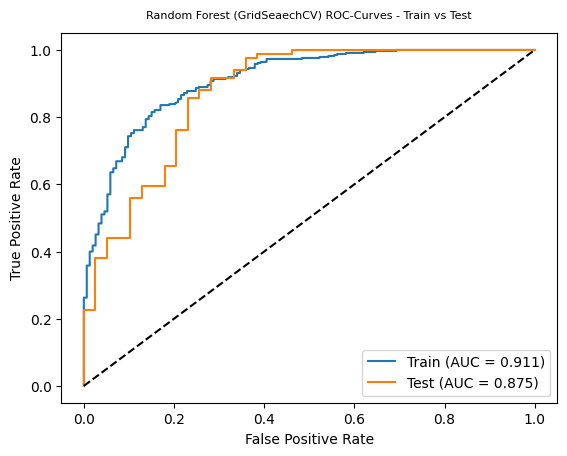

In [33]:
# plotting the curve
plt.plot(train_fpr, train_tpr, label=f'Train (AUC = {train_auc:.3f})')
plt.plot(test_fpr, test_tpr, label=f'Test (AUC = {test_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')

# set labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Random Forest (GridSeaechCV) ROC-Curves - Train vs Test", y=1.02, fontsize=8)
plt.legend()
plt.show()

## Support Vector Classification - SVC (BayesSearchCV)

### Model Trainign with Bayesian Hyperparameter Optimization

In [34]:
# Standardize features
svc_scaler = StandardScaler()
x_train_scale = svc_scaler.fit_transform(x_train)
x_test_scale = svc_scaler.fit_transform(x_test)

In [35]:
# hyperparameter tuning space
svc_param_space = {
    'C': Real(0.1, 100, prior='log-uniform'),
    'gamma': Real(0.001, 1, prior='log-uniform'),
    'kernel': Categorical(['rbf', 'linear']),
    'class_weight': Categorical(['balanced'])
}

In [36]:
# initialize base model
svc = SVC(probability=True, random_state=42)

# BayesSearch optimization
svc_bayes = BayesSearchCV(
    svc,
    svc_param_space,
    cv=cv,
    scoring=scoring_metric,
    n_iter = 20,
    n_jobs=-1,
    random_state=42
)

In [37]:
# train model and identify best estimator
svc_bayes.fit(x_train_scale, y_train)

models['SVC (BayesSearchCV)'] = svc_bayes.best_estimator_
models['SVC Scaler'] = svc_scaler

### Apply Model to Make Prediction and Get Probabilities

In [38]:
# make prediction on training and test set
train_pred = models['SVC (BayesSearchCV)'].predict(x_train_scale)
test_pred = models['SVC (BayesSearchCV)'].predict(x_test_scale)

In [39]:
# get predicted probabilities
train_proba = models['SVC (BayesSearchCV)'].predict_proba(x_train_scale)[:, 1]
test_proba = models['SVC (BayesSearchCV)'].predict_proba(x_test_scale)[:, 1]

In [40]:
# store results
predictions['SVC (BayesSearchCV)'] = test_pred
probability['SVC (BayesSearchCV)'] = test_proba

### Evaluation of The Model Performance

In [41]:
# Training Metrics
train_auc_roc = roc_auc_score(y_train, train_proba)             # ROC-AUC score
train_auc_pr = average_precision_score(y_train, train_proba)    # average precision
train_acc = accuracy_score(y_train, train_pred)                 # accuracy score
train_precision = precision_score(y_train, train_pred)          # precision score
train_recall = recall_score(y_train, train_pred)                # recall score
train_f1 = f1_score(y_train, train_pred)                        # f1 score
train_accuracy = accuracy_score(y_train, train_pred)            # accuracy score

In [42]:
# Test Metrics
test_auc_roc = roc_auc_score(y_test, test_proba)             # ROC-AUC score
test_auc_pr = average_precision_score(y_test, test_proba)    # average precision
test_acc = accuracy_score(y_test, test_pred)                 # accuracy score
test_precision = precision_score(y_test, test_pred)          # precision score
test_recall = recall_score(y_test, test_pred)                # recall score
test_f1 = f1_score(y_test, test_pred)                        # f1 score
test_accuracy = accuracy_score(y_test, test_pred)            # accuracy score

In [43]:
# performance table
print("=== Optimized SVC (BayesSearchCV) Performance ===")

metrics = [
    ("AUC-ROC", train_auc_roc, test_auc_roc),
    ('AUC-PR', train_auc_pr, test_auc_pr),
    ("Precision", train_precision, test_precision),
    ("Recall", train_recall, test_recall),
    ("F1-Score", train_f1, test_f1),
    ("Accuracy", train_acc, test_acc),
]

# Print header
print(f"{'Metric':<15}{'Training':<12}{'Test':<12}")
print("-" * 39)

# Print each row using a loop
for name, train_val, test_val in metrics:
    print(f"{name:<15}{train_val:<12.4f}{test_val:<12.4f}")

=== Optimized SVC (BayesSearchCV) Performance ===
Metric         Training    Test        
---------------------------------------
AUC-ROC        0.8422      0.8190      
AUC-PR         0.8914      0.8733      
Precision      0.8945      0.8475      
Recall         0.6328      0.5952      
F1-Score       0.7413      0.6993      
Accuracy       0.6967      0.6504      


In [44]:
# store test set performance
performance.append({
        'Model': 'SVC (BayesSearchCV)',
        'AUC-ROC': test_auc_roc,
        'AUC-PR': test_auc_pr,
        'Precision': test_precision,
        'Recall': test_recall,
        'F1-Score': test_f1,
        'Accuracy': test_accuracy
    })

### ROC Curves

In [45]:
# roc curve for training and testing set
train_fpr, train_tpr, _ = roc_curve(y_train, train_proba)
test_fpr, test_tpr, _ = roc_curve(y_test, test_proba)

In [46]:
# calculate AUC for training and testing set
train_auc = auc(train_fpr, train_tpr)
test_auc = auc(test_fpr, test_tpr)

In [47]:
# figure size
plt.figure(figsize=(8, 4))

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

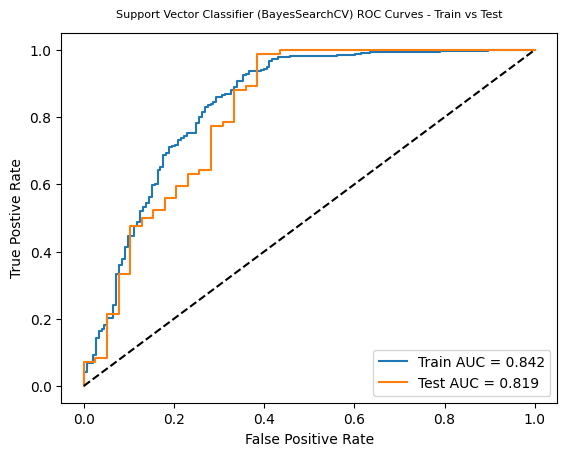

In [48]:
# plotting the curve
plt.plot(train_fpr, train_tpr, label=f'Train AUC = {train_auc:.3f}')
plt.plot(test_fpr, test_tpr, label=f'Test AUC = {test_auc:.3f}')
plt.plot([0, 1],  [0, 1], 'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Postive Rate")
plt.title('Support Vector Classifier (BayesSearchCV) ROC Curves - Train vs Test',  y=1.02, fontsize=8)

plt.legend()
plt.show()

## LightGBM (Optuna Optimization)

### Model Training with Optuna Optimization

In [49]:
# define the objective function for Optuna optimization
def lgb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', -1, 10),
        'num_leaves': trial.suggest_int('num_leaves', 20, 200),                     # more flexibility in leaf splits
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),        # min samples in leaf
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'random_state': 42,
        'n_jobs': -1,
        'class_weight': 'balanced',
        'force_col_wise': True                                                      # avoid col-wise threading warning
    }

    model = lgb.LGBMClassifier(**params, verbose=-1)
    scores = cross_val_score(model, x_train, y_train, cv=cv, scoring=scoring_metric)

    return scores.mean()

In [50]:
# create an Optuna study to maximize the objective
study_lgb = optuna.create_study(direction='maximize')

# run the optimization process for 30 trials
study_lgb.optimize(lgb_objective, n_trials=30, show_progress_bar=False)

In [51]:
# train the final LightGBM model using the best parameters found by Optuna
lgb_best = lgb.LGBMClassifier(**study_lgb.best_params, random_state=42, class_weight='balanced')

# fit the best model on the entire training data
lgb_best.fit(x_train, y_train)
models['LightGBM (Optuna)'] = lgb_best

### Apply Model to Make Prediction and Get Probabilities

In [52]:
# make prediction on training and test set
train_pred = models['LightGBM (Optuna)'].predict(x_train)
test_pred = models['LightGBM (Optuna)'].predict(x_test)

In [53]:
# get predicted probabilities
train_proba = models['LightGBM (Optuna)'].predict_proba(x_train)[:, 1]
test_proba = models['LightGBM (Optuna)'].predict_proba(x_test)[:, 1]

In [54]:
# store results
predictions["LightGBM (Optuna)"] = test_pred
probability["LightGBM (Optuna)"] = test_proba

### Evaluation of The Model Performance

In [55]:
# Training Metrics
train_auc_roc = roc_auc_score(y_train, train_proba)             # ROC-AUC score
train_auc_pr = average_precision_score(y_train, train_proba)    # average precision
train_acc = accuracy_score(y_train, train_pred)                 # accuracy score
train_precision = precision_score(y_train, train_pred)          # precision score
train_recall = recall_score(y_train, train_pred)                # recall score
train_f1 = f1_score(y_train, train_pred)                        # f1 score
train_accuracy = accuracy_score(y_train, train_pred)            # accuracy score

In [56]:
# Test Metrics
test_auc_roc = roc_auc_score(y_test, test_proba)             # ROC-AUC score
test_auc_pr = average_precision_score(y_test, test_proba)    # average precision
test_acc = accuracy_score(y_test, test_pred)                 # accuracy score
test_precision = precision_score(y_test, test_pred)          # precision score
test_recall = recall_score(y_test, test_pred)                # recall score
test_f1 = f1_score(y_test, test_pred)                        # f1 score
test_accuracy = accuracy_score(y_test, test_pred)            # accuracy score

In [57]:
# performance table
print("=== Optimized LightGBM (Optuna) Performance ===")

metrics = [
    ("AUC-ROC", train_auc_roc, test_auc_roc),
    ('AUC-PR', train_auc_pr, test_auc_pr),
    ("Precision", train_precision, test_precision),
    ("Recall", train_recall, test_recall),
    ("F1-Score", train_f1, test_f1),
    ("Accuracy", train_acc, test_acc),
]

# Print header
print(f"{'Metric':<15}{'Training':<12}{'Test':<12}")
print("-" * 39)

# Print each row using a loop
for name, train_val, test_val in metrics:
    print(f"{name:<15}{train_val:<12.4f}{test_val:<12.4f}")

=== Optimized LightGBM (Optuna) Performance ===
Metric         Training    Test        
---------------------------------------
AUC-ROC        0.9087      0.8745      
AUC-PR         0.9556      0.9205      
Precision      0.8832      0.8765      
Recall         0.8806      0.8452      
F1-Score       0.8819      0.8606      
Accuracy       0.8381      0.8130      


In [58]:
# store test set performance
performance.append({
        'Model': 'LightGBM (Optuna)',
        'AUC-ROC': test_auc_roc,
        'AUC-PR': test_auc_pr,
        'Precision': test_precision,
        'Recall': test_recall,
        'F1-Score': test_f1,
        'Accuracy': test_accuracy
    })

### ROC Curves

In [59]:
# roc curve for training and testing set
train_fpr, train_tpr, _ = roc_curve(y_train, train_proba)
test_fpr, test_tpr, _ = roc_curve(y_test, test_proba)

In [60]:
# calculate AUC for training and testing set
train_auc = auc(train_fpr, train_tpr)
test_auc = auc(test_fpr, test_tpr)

In [61]:
# figure size
plt.figure(figsize=(8, 4))

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

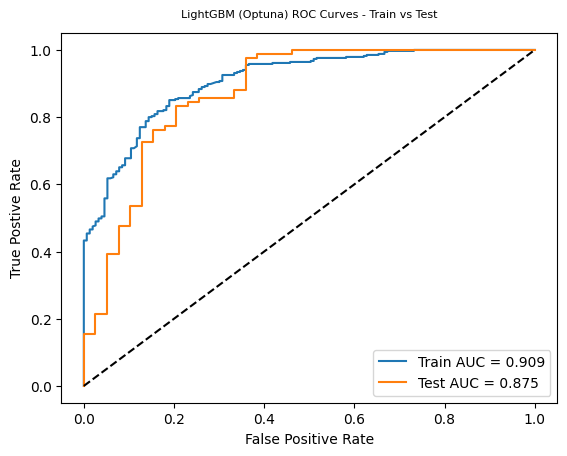

In [62]:
# plotting the curve
plt.plot(train_fpr, train_tpr, label=f'Train AUC = {train_auc:.3f}')
plt.plot(test_fpr, test_tpr, label=f'Test AUC = {test_auc:.3f}')
plt.plot([0, 1],  [0, 1], 'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Postive Rate")
plt.title('LightGBM (Optuna) ROC Curves - Train vs Test',  y=1.02, fontsize=8)

plt.legend()
plt.show()

## XGBoost (Optuna Optimization)

### Model Training with Optuna Optimization

In [63]:
# define the objective function for Optuna optimization
def xgb_objective(trial):
    scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),               # min samples in leaf
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 15),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'scale_pos_weight': scale_pos_weight,
        'random_state': 42,
        'n_jobs': -1,
        'eval_metric': 'logloss',
        'use_label_encoder': False                                                      # prevents warning in classification                                                          # avoid col-wise threading warning
    }

    model = xgb.XGBClassifier(**params)
    scores = cross_val_score(model, x_train, y_train, cv=cv, scoring=scoring_metric)

    return scores.mean()

In [64]:
# create an Optuna study to maximize the objective
study_xgb = optuna.create_study(direction='maximize')

# run the optimization process for 30 trials
study_xgb.optimize(xgb_objective, n_trials=30, show_progress_bar=False)

In [65]:
# train the final XGBoost model using the best parameters found by Optuna
xgb_best = xgb.XGBClassifier(**study_xgb.best_params, random_state=42)

# fit the best model on the entire training data
xgb_best.fit(x_train, y_train)
models['XGBoost (Optuna)'] = xgb_best

### Apply Model to Make Prediction and Get Probabilities

In [66]:
# make prediction on training and test set
train_pred = models['XGBoost (Optuna)'].predict(x_train)
test_pred = models['XGBoost (Optuna)'].predict(x_test)

In [67]:
# get predicted probabilities
train_proba = models['XGBoost (Optuna)'].predict_proba(x_train)[:, 1]
test_proba = models['XGBoost (Optuna)'].predict_proba(x_test)[:, 1]

In [68]:
# store results
predictions["XGBoost (Optuna)"] = test_pred
probability["XGBoost (Optuna)"] = test_proba

### Evaluation of The Model Performance

In [69]:
# Training Metrics
train_auc_roc = roc_auc_score(y_train, train_proba)             # ROC-AUC score
train_auc_pr = average_precision_score(y_train, train_proba)    # average precision
train_acc = accuracy_score(y_train, train_pred)                 # accuracy score
train_precision = precision_score(y_train, train_pred)          # precision score
train_recall = recall_score(y_train, train_pred)                # recall score
train_f1 = f1_score(y_train, train_pred)                        # f1 score
train_accuracy = accuracy_score(y_train, train_pred)            # accuracy score

In [70]:
# Test Metrics
test_auc_roc = roc_auc_score(y_test, test_proba)             # ROC-AUC score
test_auc_pr = average_precision_score(y_test, test_proba)    # average precision
test_acc = accuracy_score(y_test, test_pred)                 # accuracy score
test_precision = precision_score(y_test, test_pred)          # precision score
test_recall = recall_score(y_test, test_pred)                # recall score
test_f1 = f1_score(y_test, test_pred)                        # f1 score
test_accuracy = accuracy_score(y_test, test_pred)            # accuracy score

In [71]:
# performance table
print("=== Optimized XGBoost (Optuna) Performance ===")

metrics = [
    ("AUC-ROC", train_auc_roc, test_auc_roc),
    ('AUC-PR', train_auc_pr, test_auc_pr),
    ("Precision", train_precision, test_precision),
    ("Recall", train_recall, test_recall),
    ("F1-Score", train_f1, test_f1),
    ("Accuracy", train_acc, test_acc),
]

# Print header
print(f"{'Metric':<15}{'Training':<12}{'Test':<12}")
print("-" * 39)

# Print each row using a loop
for name, train_val, test_val in metrics:
    print(f"{name:<15}{train_val:<12.4f}{test_val:<12.4f}")

=== Optimized XGBoost (Optuna) Performance ===
Metric         Training    Test        
---------------------------------------
AUC-ROC        0.8880      0.8930      
AUC-PR         0.9384      0.9383      
Precision      0.7956      0.8469      
Recall         0.9761      0.9881      
F1-Score       0.8767      0.9121      
Accuracy       0.8115      0.8699      


In [72]:
# store test set performance
performance.append({
        'Model': 'XGBoost (Optuna)',
        'AUC-ROC': test_auc_roc,
        'AUC-PR': test_auc_pr,
        'Precision': test_precision,
        'Recall': test_recall,
        'F1-Score': test_f1,
        'Accuracy': test_accuracy
    })

### ROC Curves

In [73]:
# roc curve for training and testing set
train_fpr, train_tpr, _ = roc_curve(y_train, train_proba)
test_fpr, test_tpr, _ = roc_curve(y_test, test_proba)

In [74]:
# calculate AUC for training and testing set
train_auc = auc(train_fpr, train_tpr)
test_auc = auc(test_fpr, test_tpr)

In [75]:
# figure size
plt.figure(figsize=(8, 4))

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

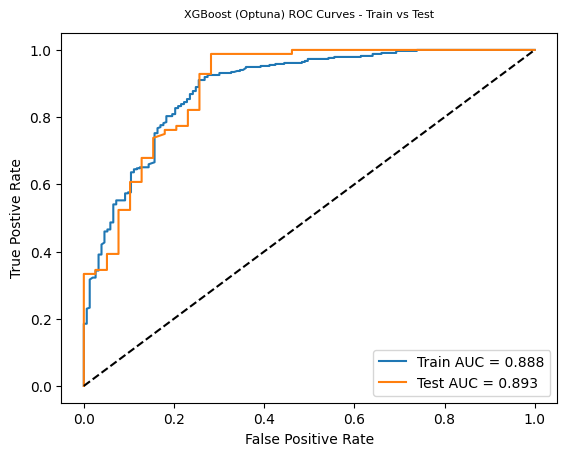

In [76]:
# plotting the curve
plt.plot(train_fpr, train_tpr, label=f'Train AUC = {train_auc:.3f}')
plt.plot(test_fpr, test_tpr, label=f'Test AUC = {test_auc:.3f}')
plt.plot([0, 1],  [0, 1], 'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Postive Rate")
plt.title('XGBoost (Optuna) ROC Curves - Train vs Test',  y=1.02, fontsize=8)

plt.legend()
plt.show()